<a href="https://colab.research.google.com/github/babsyco/C19_cases_deaths_vaccinations/blob/main/vaccine_rollout1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset available here: https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv



In [12]:
###########
# IMPORTS #
###########
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from IPython.display import Javascript
from datetime import datetime
from pandas.api.types import is_numeric_dtype
from google.colab import files
import os
import time
import getpass
import statistics
import math

In [13]:
######################
# IMPORT RAW DATASET #
######################
# (Raw dataset summary displayed at end of notebook)
OWID_data_url = ''
OWID_dataRaw_df = ''
OWID_dataRaw_df_dimensions = ''
OWID_dataRaw_locations = ''
OWID_latest_date = ''

OWID_data_url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
OWID_dataRaw_df = pd.read_csv(OWID_data_url, error_bad_lines=False)

# RAW DATA PARAMETERS
OWID_dataRaw_df_dimensions = OWID_dataRaw_df.shape
OWID_dataRaw_locations = OWID_dataRaw_df.location.unique()
OWID_dataRaw_df['date'] = pd.to_datetime(OWID_dataRaw_df['date'])
OWID_dates = OWID_dataRaw_df['date'].to_list()
OWID_latest_date = OWID_dataRaw_df['date'].to_list()[-1].strftime('%b %d, %Y')

In [14]:
########################
# PRE-PROCESS RAW DATA #
########################
min_population = 1000000
OWID_preProcessed_data_df = ''

OWID_preProcessed_data_df = OWID_dataRaw_df.copy()
# CONVERT 'date' COLUMN TO DATETIME DATA TYPE
OWID_preProcessed_data_df['date'] = pd.to_datetime(OWID_preProcessed_data_df['date'])
# REMOVE SMALL LOCATIONS
OWID_preProcessed_data_df = OWID_preProcessed_data_df[OWID_preProcessed_data_df.population >= min_population]
# SET 'location' AS ROW INDEX
OWID_preProcessed_data_df.set_index('location', inplace=True)
#RE-SCALE 'total_vaccinations_per_hundred' AND 'people_fully_vaccinated_per_hundred' TO PER MILLION
OWID_preProcessed_data_df['total_vaccinations_per_hundred'] *= 10000
OWID_preProcessed_data_df['people_fully_vaccinated_per_hundred'] *= 10000
OWID_preProcessed_data_df.rename(columns = {"total_vaccinations_per_hundred":"total_vaccinations_per_million",
                                            "people_fully_vaccinated_per_hundred":"people_fully_vaccinated_per_million"}, inplace=True)

In [15]:
################################
# CREATE DATASETS TO BE USED #
################################
perCapita_daily_columns = []
perCapita_cumulative_columns = []
OWID_perCapita_daily_df = ''
OWID_perCapita_cumulative_df = ''

perCapita_daily_columns = ["date","new_cases_smoothed_per_million", "new_deaths_smoothed_per_million",
                           "new_vaccinations_smoothed_per_million"]
perCapita_cumulative_columns = ["date", "total_cases_per_million", "total_deaths_per_million",
                                "total_vaccinations_per_million", "people_fully_vaccinated_per_million"]

# CREATE DATAFRAMES
OWID_perCapita_daily_df = OWID_preProcessed_data_df[perCapita_daily_columns]
OWID_perCapita_cumulative_df = OWID_preProcessed_data_df[perCapita_cumulative_columns]

In [16]:
##############
# SAVE PLOTS #
##############

if (input("The latest date in the dataset is %s. Save/download plots? y/n: " 
          % OWID_latest_date).lower()[0] == 'y'):
  save_files = True
  print("\nPlots will be saved/downloaded.")
else:
  save_files = False
  print("Plots will not be saved/downloaded.")



The latest date in the dataset is Mar 24, 2021. Save/download plots? y/n: y

Plots will be saved/downloaded.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

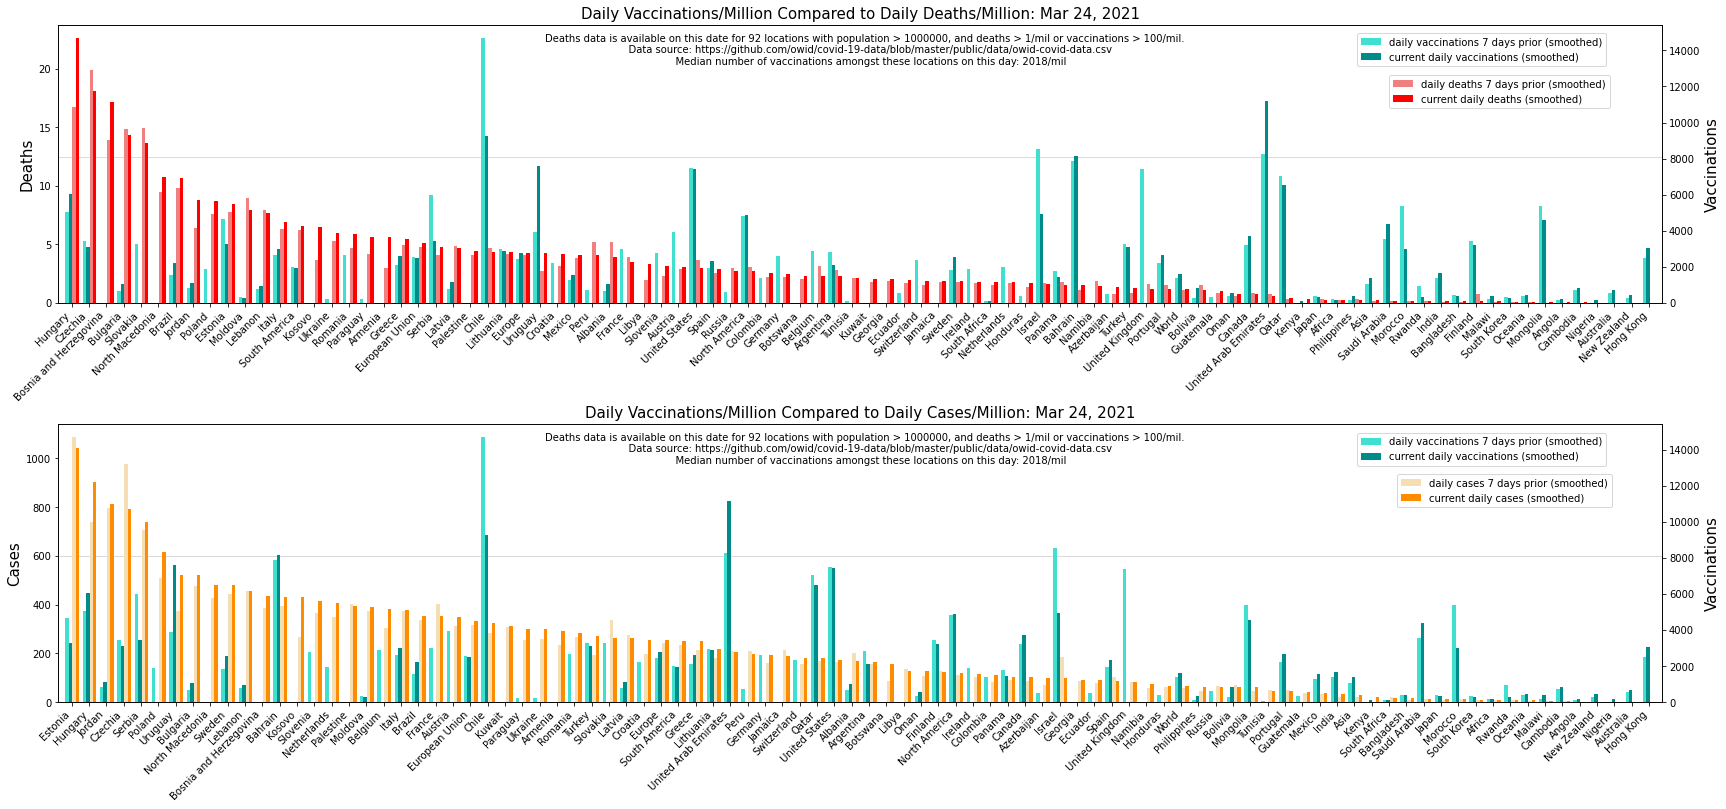

In [17]:
#########################
# PER CAPITA DAILY DATA #
#########################
num_days_back = 7
legend_labels = []
x_vals = []
bar_width = 0.2
bar_transparency = 1
date_offset = 0
current_date = OWID_dates[-1+date_offset]
past_date = OWID_dates[-1*(num_days_back-date_offset)]
daily_deaths_threshold = 1 # include locations with more than this per million
daily_vax_threshold = 100

# Remove locations below daily deaths and vaccinations thresholds
OWID_perCapita_daily_filtered_df = OWID_perCapita_daily_df.query('new_deaths_smoothed_per_million > %d or new_vaccinations_smoothed_per_million > %d' %
                                                                 (daily_deaths_threshold, daily_vax_threshold))
# Temp datasets: extract current and past date rows for each location
temp_current_df = OWID_perCapita_daily_filtered_df.sort_values('date').groupby('location').apply(lambda x: x[x['date'] == current_date])
temp_past_df = OWID_perCapita_daily_filtered_df.sort_values('date').groupby('location').apply(lambda x: x[x['date'] == past_date])

# median daily vaccinations
median_daily_vaxs = int(temp_current_df['new_vaccinations_smoothed_per_million'].median())

# CREATE PLOTS
x_vals = np.arange(len(temp_current_df.index))
fig, axs = plt.subplots(2, 1, figsize=[int(len(x_vals)/4),10])
fig.tight_layout(h_pad=10)
inclusion_string = "Deaths data is available on this date for %d locations with population > %d, and deaths > %d/mil or vaccinations > %d/mil.\n\
    Data source: https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv\n\
    Median number of vaccinations amongst these locations on this day: %d/mil" \
     % (len([i[0] for i in temp_current_df.index]), min_population, daily_deaths_threshold, daily_vax_threshold, median_daily_vaxs)

# death/vaccinations (top)
# sort temp datasets by "new_deaths_smoothed_per_million"
temp_current_df = temp_current_df.sort_values("new_deaths_smoothed_per_million", ascending=False)
temp_past_df = temp_past_df.reindex(temp_current_df.index)
# plot
ax_top1 = axs[0]
ax_top2 = ax_top1.twinx()
ax_top1.set_xlim([-0.5,len(x_vals)])
ax_top2.set_xlim([-0.5,len(x_vals)])
ax_top2.set_ylabel('Vaccinations', fontsize=15)
ax_top1.set_ylabel('Deaths', fontsize=15)
ax_top2.set_title("Daily Vaccinations/Million Compared to Daily Deaths/Million: %s" % current_date.strftime('%b %d, %Y'), fontsize=15)
ax_top1.set_xticks(x_vals + bar_width*1.3)
ax_top1.set_xticklabels([i[0] for i in temp_current_df.index], rotation = 45, ha='right')
ax_top1.bar(x_vals + bar_width*2, temp_past_df["new_deaths_smoothed_per_million"], alpha=bar_transparency, color='lightcoral', width=bar_width, zorder=1)
ax_top1.bar(x_vals + bar_width*3, temp_current_df["new_deaths_smoothed_per_million"], alpha=bar_transparency, color='red', width=bar_width, zorder=1)
ax_top1.hlines(ax_top1.get_yticks()[-1]/2, ax_top1.get_xlim()[0], ax_top1.get_xlim()[1], color='lightgray', zorder=0, linewidth=0.8, label='_nolegend_')
ax_top2.bar(x_vals, temp_past_df["new_vaccinations_smoothed_per_million"], color='turquoise', width=bar_width, zorder=1)
ax_top2.bar(x_vals + bar_width, temp_current_df["new_vaccinations_smoothed_per_million"], alpha=bar_transparency, color='darkcyan', width=bar_width, zorder=1)
ax_top2.legend(['daily vaccinations %d days prior (smoothed)'%num_days_back, 'current daily vaccinations (smoothed)'], loc=[0.81,0.85])
ax_top1.legend(['daily deaths %d days prior (smoothed)'%num_days_back, 'current daily deaths (smoothed)'], loc=[0.83, 0.7])
ax_top2.text(ax_top2.get_xlim()[1]/2, ax_top2.get_ylim()[1]*0.97, inclusion_string, va='top', ha='center', fontsize=10)

# cases/vaccinations (bottom)
# sort temp datasets by "new_cases_smoothed_per_million"
temp_current_df = temp_current_df.sort_values("new_cases_smoothed_per_million", ascending=False)
temp_past_df = temp_past_df.reindex(temp_current_df.index)
# plot
ax_bottom1 = axs[1]
ax_bottom2 = ax_bottom1.twinx()
ax_bottom2.set_ylabel('Vaccinations', fontsize=15)
ax_bottom1.set_ylabel('Cases', fontsize=15)
ax_bottom2.set_title("Daily Vaccinations/Million Compared to Daily Cases/Million: %s" % current_date.strftime('%b %d, %Y'), fontsize=15)
ax_bottom1.set_xticks(x_vals + bar_width*1.3)
ax_bottom1.set_xticklabels([i[0] for i in temp_current_df.index], rotation = 45, ha='right')
ax_bottom1.set_xlim([-0.5,len(x_vals)])
ax_bottom1.bar(x_vals + bar_width*2, temp_past_df["new_cases_smoothed_per_million"], alpha=bar_transparency, color='wheat', width=bar_width, zorder=1)
ax_bottom1.bar(x_vals + bar_width*3, temp_current_df["new_cases_smoothed_per_million"], alpha=bar_transparency, color='darkorange', width=bar_width, zorder=1)
ax_bottom1.hlines(ax_bottom1.get_yticks()[-1]/2, ax_bottom1.get_xlim()[0], ax_bottom1.get_xlim()[1], color='lightgray', zorder=0, linewidth=0.8, label='_nolegend_')
ax_bottom2.bar(x_vals, temp_past_df["new_vaccinations_smoothed_per_million"], color='turquoise', width=bar_width, zorder=1)
ax_bottom2.bar(x_vals + bar_width, temp_current_df["new_vaccinations_smoothed_per_million"], alpha=bar_transparency, color='darkcyan', width=bar_width, zorder=1)
ax_bottom2.legend(['daily vaccinations %d days prior (smoothed)'%num_days_back, 'current daily vaccinations (smoothed)'], loc=[0.81,0.85])
ax_bottom1.legend(['daily cases %d days prior (smoothed)'%num_days_back, 'current daily cases (smoothed)'], loc=[0.835, 0.7])
ax_bottom2.text(ax_bottom2.get_xlim()[1]/2, ax_bottom2.get_ylim()[1]*0.97, inclusion_string, va='top',  ha='center', fontsize=10)

# save file
if save_files:
  if not os.path.exists('plots'):
    os.makedirs('plots')
  filename = 'plots/daily_vaccine_vs_deaths_per_capita'
  plt.savefig(filename, bbox_inches = 'tight')
  files.download(filename+'.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

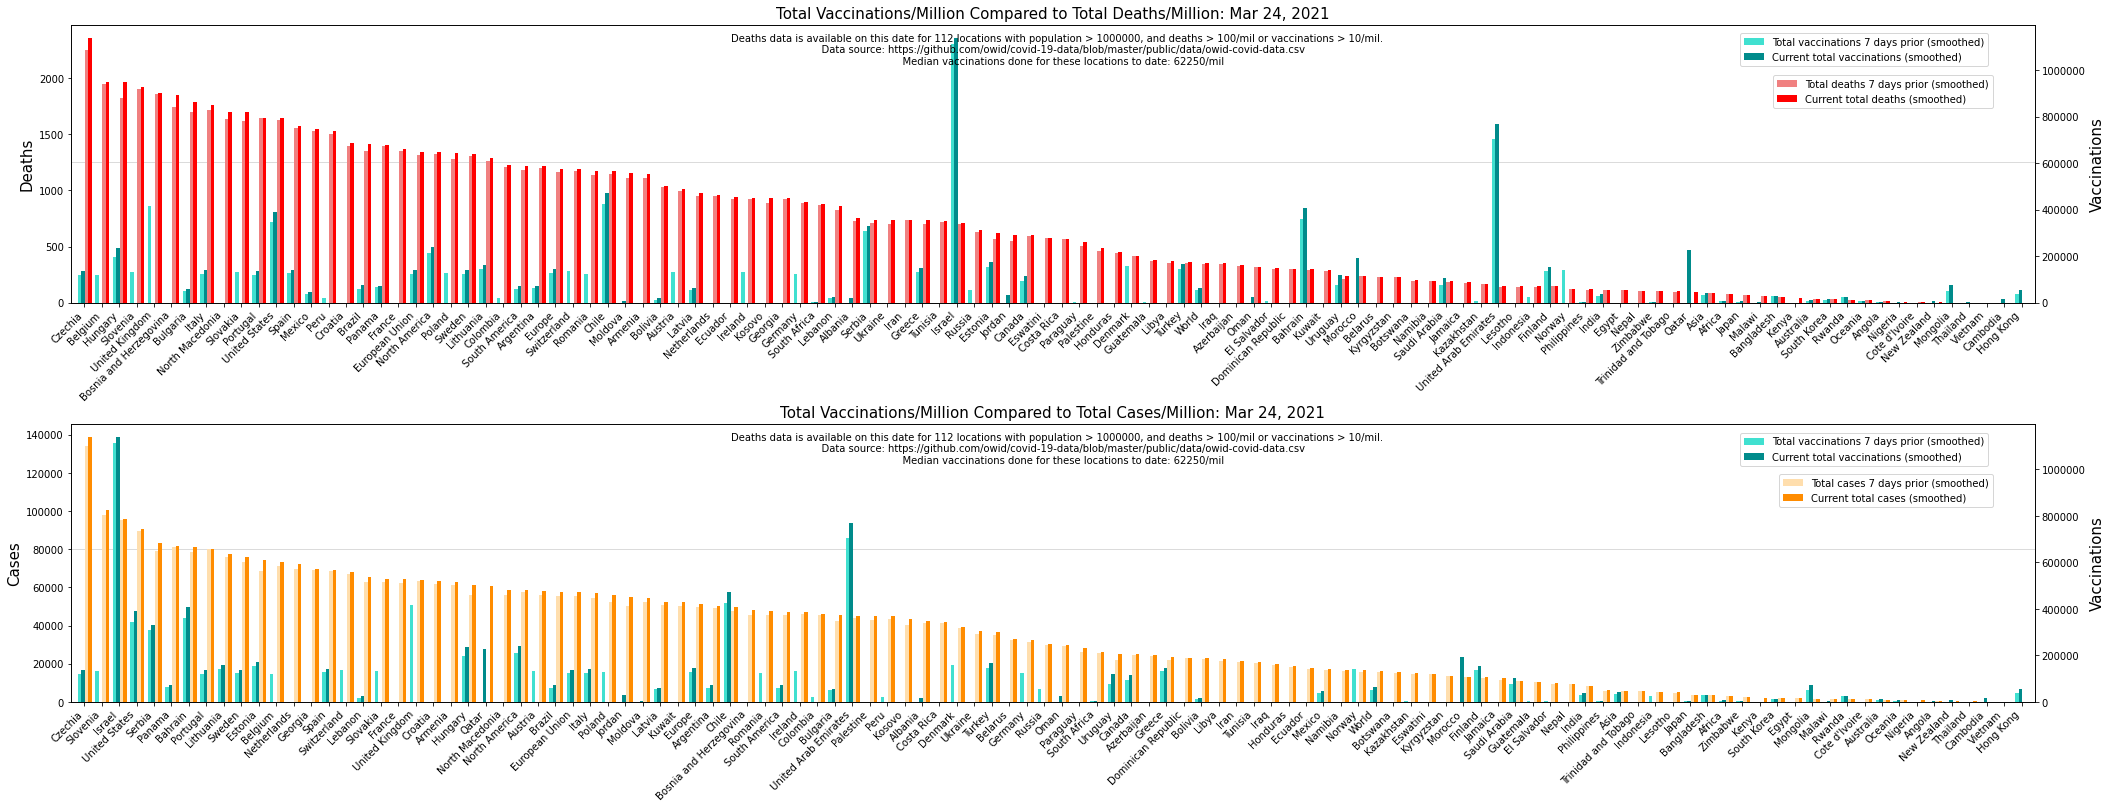

In [18]:
#########################
# CUMULATIVE DAILY DATA #
#########################
num_days_back = 7
legend_labels = []
x_vals = []
bar_width = 0.2
date_offset = 0
current_date = OWID_dates[-1+date_offset]
past_date = OWID_dates[-1*(num_days_back-date_offset)]
cumulative_deaths_threshold = 100 # include locations with more than this per million
cumulative_vax_threshold = 10

# Remove locations below daily deaths and vaccinations thresholds
OWID_perCapita_cumulative_filtered_df = OWID_perCapita_cumulative_df.query('total_deaths_per_million > %d or total_vaccinations_per_million > %d' %
                                                                 (cumulative_deaths_threshold, cumulative_vax_threshold))
# Temp datasets: extract current and past date rows for each location
temp_current_df = OWID_perCapita_cumulative_filtered_df.sort_values('date').groupby('location').apply(lambda x: x[x['date'] == current_date])
temp_past_df = OWID_perCapita_cumulative_filtered_df.sort_values('date').groupby('location').apply(lambda x: x[x['date'] == past_date])

# median total vaccinations
median_total_vaxs = int(temp_current_df['total_vaccinations_per_million'].median())

# CREATE PLOTS
x_vals = np.arange(len(temp_current_df.index))
fig, axs = plt.subplots(2, 1, figsize=[int(len(x_vals)/4),10])
axs[0].ticklabel_format(scilimits=[0, 10])
axs[1].ticklabel_format(scilimits=[0, 10])
fig.tight_layout(h_pad=10)
inclusion_string = "Deaths data is available on this date for %d locations with population > %d, and deaths > %d/mil or vaccinations > %d/mil.\n\
    Data source: https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv\n\
    Median vaccinations done for these locations to date: %d/mil" \
     % (len([i[0] for i in temp_current_df.index]), min_population, cumulative_deaths_threshold, cumulative_vax_threshold, median_total_vaxs)

# death/vaccinations (top)
# sort temp datasets by deaths
temp_current_df = temp_current_df.sort_values("total_deaths_per_million", ascending=False)
temp_past_df = temp_past_df.reindex(temp_current_df.index)
# plot
ax_top1 = axs[0]
ax_top2 = ax_top1.twinx()
ax_top2.ticklabel_format(scilimits=[0, 10])
ax_top2.set_ylabel('Vaccinations', fontsize=15)
ax_top1.set_ylabel('Deaths', fontsize=15)
ax_top1.set_title("Total Vaccinations/Million Compared to Total Deaths/Million: %s" % current_date.strftime('%b %d, %Y'), fontsize=15)
ax_top1.set_xticks(x_vals + bar_width*1.3)
ax_top1.set_xlim([-0.5,len(x_vals)])
ax_top1.set_xticklabels([i[0] for i in temp_current_df.index], rotation = 45, ha='right')
ax_top1.bar(x_vals + bar_width*2, temp_past_df["total_deaths_per_million"], alpha=bar_transparency, color='lightcoral', width=bar_width, zorder=1)
ax_top1.bar(x_vals + bar_width*3, temp_current_df["total_deaths_per_million"], alpha=bar_transparency, color='red', width=bar_width, zorder=1)
ax_top1.hlines(ax_top1.get_yticks()[-1]/2, ax_top1.get_xlim()[0], ax_top1.get_xlim()[1], color='lightgray', zorder=0, linewidth=0.8, label='_nolegend_')
ax_top2.bar(x_vals, temp_past_df["total_vaccinations_per_million"], color='turquoise', width=bar_width, zorder=1)
ax_top2.bar(x_vals + bar_width, temp_current_df["total_vaccinations_per_million"], alpha=bar_transparency, color='darkcyan', width=bar_width, zorder=1)
ax_top2.legend(['Total vaccinations %d days prior (smoothed)'%num_days_back, 'Current total vaccinations (smoothed)'], loc=[0.85,0.85])
ax_top1.legend(['Total deaths %d days prior (smoothed)'%num_days_back, 'Current total deaths (smoothed)'], loc=[0.867, 0.7])
ax_top2.text(ax_top2.get_xlim()[1]/2, ax_top2.get_ylim()[1]*0.97, inclusion_string, ha='center', va='top', fontsize=10, zorder=2)

# cases/vaccinations (bottom)
# sort temp datasets by cases
temp_current_df = temp_current_df.sort_values("total_cases_per_million", ascending=False)
temp_past_df = temp_past_df.reindex(temp_current_df.index)
#plot
ax_bottom1 = axs[1]
ax_bottom2 = ax_bottom1.twinx()
ax_bottom2.ticklabel_format(scilimits=[0, 10])
ax_bottom2.set_ylabel('Vaccinations', fontsize=15)
ax_bottom1.set_ylabel('Cases', fontsize=15)
ax_bottom1.set_title("Total Vaccinations/Million Compared to Total Cases/Million: %s" % current_date.strftime('%b %d, %Y'), fontsize=15)
ax_bottom1.set_xticks(x_vals + bar_width*1.3)
ax_bottom1.set_xticklabels([i[0] for i in temp_current_df.index], rotation = 45, ha='right')
ax_bottom1.set_xlim([-0.5,len(x_vals)])
ax_bottom1.bar(x_vals + bar_width*2, temp_past_df["total_cases_per_million"], alpha=bar_transparency, color='navajowhite', width=bar_width)
ax_bottom1.bar(x_vals + bar_width*3, temp_current_df["total_cases_per_million"], alpha=bar_transparency, color='darkorange', width=bar_width)
ax_bottom1.hlines(ax_bottom1.get_yticks()[-1]/2, ax_bottom1.get_xlim()[0], ax_bottom1.get_xlim()[1], color='lightgray', zorder=0, linewidth=0.8, label='_nolegend_')
ax_bottom2.bar(x_vals, temp_past_df["total_vaccinations_per_million"], color='turquoise', width=bar_width)
ax_bottom2.bar(x_vals + bar_width, temp_current_df["total_vaccinations_per_million"], alpha=bar_transparency, color='darkcyan', width=bar_width)
ax_bottom2.legend(['Total vaccinations %d days prior (smoothed)'%num_days_back, 'Current total vaccinations (smoothed)'], loc=[0.85,0.85])
ax_bottom1.legend(['Total cases %d days prior (smoothed)'%num_days_back, 'Current total cases (smoothed)'], loc=[0.87, 0.7])
ax_bottom2.text(ax_top2.get_xlim()[1]/2, ax_top2.get_ylim()[1]*0.97, inclusion_string, ha='center', va='top', fontsize=10, zorder=2)

# save file
if save_files:
  if not os.path.exists('plots'):
    os.makedirs('plots')
  filename = 'plots/cumulative_vaccine_vs_deaths_per_capita'
  plt.savefig(filename, bbox_inches = 'tight')
  files.download(filename+'.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

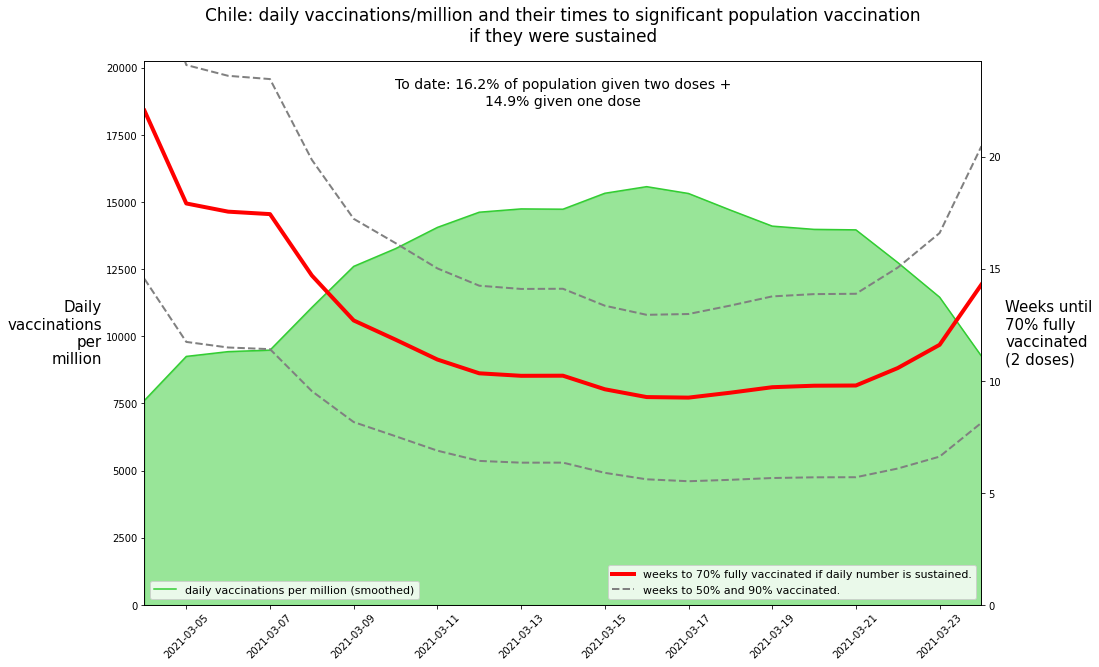

In [22]:
#############################
# WEEKS TO FULL VACCINATION #
#############################
location = 'Chile'
last_n_days = 21
HI_threshold = 0.7
times_to_HI = []
lowerInterval_HI_times = []
upperInterval_HI_times = []
daily_vaxs = []
dates = []


# select relevant columns for location
location_daily_vaxPerMil_df = OWID_preProcessed_data_df.loc[location, ['new_vaccinations_smoothed_per_million', 'date', 'total_vaccinations_per_million', 
                                                                       'people_fully_vaccinated_per_million']]
# get date of first daily vaccination value
first_vax_date = location_daily_vaxPerMil_df.set_index('date').notna().idxmax()
location_daily_vaxPerMil_df = location_daily_vaxPerMil_df[location_daily_vaxPerMil_df['date'] >= first_vax_date[0]]

# get times_to_HI figures
for i in range(last_n_days):
  if location_daily_vaxPerMil_df.iloc[-1*last_n_days+i]['new_vaccinations_smoothed_per_million'] > 0:
    daily_fig = location_daily_vaxPerMil_df.iloc[-1*last_n_days+i]['new_vaccinations_smoothed_per_million']
    total_fig = location_daily_vaxPerMil_df.iloc[-1*last_n_days+i]['total_vaccinations_per_million']
    fully_vaxxed_fig = location_daily_vaxPerMil_df.iloc[-1*last_n_days+i]['people_fully_vaccinated_per_million']
    if math.isnan(fully_vaxxed_fig):
      fully_vaxxed_fig = 0
    daily_vaxs.append(daily_fig)
    dates.append(location_daily_vaxPerMil_df.iloc[-1*last_n_days+i]['date'])
    # append lists for plotting
    times_to_HI.append(((HI_threshold*1000000 - fully_vaxxed_fig)*2 - (total_fig-2*fully_vaxxed_fig))/(daily_fig*7))
    lowerInterval_HI_times.append((((HI_threshold-0.2)*1000000 - fully_vaxxed_fig)*2 - (total_fig-2*fully_vaxxed_fig))/(daily_fig*7)) 
    upperInterval_HI_times.append((((HI_threshold+0.2)*1000000 - fully_vaxxed_fig)*2 - (total_fig-2*fully_vaxxed_fig))/(daily_fig*7))

# Vaccination breakdowns
percent_single_dose = (location_daily_vaxPerMil_df['total_vaccinations_per_million'].tail(1) - location_daily_vaxPerMil_df['people_fully_vaccinated_per_million'].tail(1)*2)/10000
percent_double_dose = location_daily_vaxPerMil_df['people_fully_vaccinated_per_million'].tail(1)/10000

# plot
fig, ax1 = plt.subplots(figsize=(15,10))
ax1.set_title('%s: daily vaccinations/million and their times to significant population vaccination\nif they were sustained' % location, fontsize=17, pad=20)
ax2 = ax1.twinx()
# ax1: daily vaxs
ax1.set_ylabel("Daily\nvaccinations\nper\nmillion", fontsize=15,rotation='horizontal', ha='right', va='center')
ax1.fill_between(dates, daily_vaxs, color='limegreen', alpha=0.5, zorder=-1)
ax1.set_ylim([0, max(daily_vaxs)*1.3])
ax1.set_xlim([dates[0], dates[-1]])
ax1.set_xticklabels(ax1.get_xticks(), rotation = 45) 
ax1.plot(dates,daily_vaxs, color='limegreen',zorder=1)
ax1.legend(['daily vaccinations per million (smoothed)'], loc='lower left', fontsize=11)
# ax2: weeks to HI
ax2.plot(dates, times_to_HI, color='red', linewidth=4)
ax2.set_ylim([0, max([x for x in times_to_HI if np.isnan(x) == False])*1.1])
ax2.plot(dates, upperInterval_HI_times, color='grey', linewidth=2, linestyle='--')
ax2.plot(dates, lowerInterval_HI_times, color='grey', linewidth=2, linestyle='--')
ax2.set_ylabel("Weeks until\n%d%% fully\nvaccinated\n(2 doses)" % int(100*HI_threshold), fontsize=15, rotation='horizontal', ha='left', va='center')
ax2.legend(['weeks to %d%% fully vaccinated if daily number is sustained.' % int(HI_threshold*100), 'weeks to %d%% and %d%% vaccinated.' % (int((HI_threshold-0.2)*100+1), int((HI_threshold+0.2)*100+1))],
           fontsize=11, loc='lower right')
if not math.isnan(percent_double_dose): 
  ax2.text(dates[int(len(dates)/2)], ax2.get_ylim()[1]*0.97, 'To date: %0.1f%% of population given two doses +\n%0.1f%% given one dose' % (percent_double_dose, percent_single_dose),
         ha='center', va='top', fontsize=14)


# save file
if save_files:
  if not os.path.exists('plots'):
    os.makedirs('plots')
  filename = 'Times_to_HI_%s' % location
  plt.savefig(filename, bbox_inches = 'tight')
  files.download(filename+'.png')

In [20]:
#####################
# DATASET SUMMARIES #
#####################

# format size of cell output
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# RAW DATASET
# Dimensions
print("\nRAW DATASET DIMENSIONS:\n\n  Rows: %d\n  Columns: %d\n" % tuple(OWID_dataRaw_df_dimensions))
# latest date
print("RAW DATASET LATEST DATE:\n\n  %s\n" % OWID_latest_date)
# Sample
print("RAW DATASET SAMPLE: First 10 rows, all columns:\n\n")
display(OWID_dataRaw_df.head(10))
# Locations
print("\n\n\nLOCATIONS INCLUDED IN RAW DATASET:")
for i in range(len(OWID_dataRaw_locations)):
  if i % 10 == 0:
    print("\n")
  if i != (len(OWID_dataRaw_locations) - 1):
    print(OWID_dataRaw_locations[i], end = ", ")
  else:
    print(OWID_dataRaw_locations[i])

print("\n\nFIELDS INCLUDED IN RAW DATASET:")
for i in range(len(OWID_dataRaw_df.columns)):
  if i % 5 == 0:
    print("\n")
  if i != (len(OWID_dataRaw_df.columns) - 1):
    print(OWID_dataRaw_df.columns[i], end = ", ")
  else:
    print(OWID_dataRaw_df.columns[i])


<IPython.core.display.Javascript object>


RAW DATASET DIMENSIONS:

  Rows: 77070
  Columns: 59

RAW DATASET LATEST DATE:

  Mar 24, 2021

RAW DATASET SAMPLE: First 10 rows, all columns:




,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
5,AFG,Asia,Afghanistan,2020-02-29,1.0,0.0,0.143,NaN,NaN,0.0,0.026,0.000,0.004,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
6,AFG,Asia,Afghanistan,2020-03-01,1.0,0.0,0.143,NaN,NaN,0.0,0.026,0.000,0.004,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.78,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
7,AFG,Asia,Afghanistan,2020-03-02,1.0,0.0,0.000,NaN,NaN,0.0,0.026,0.000,0.000,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.78,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
8,AFG,Asia,Afghanistan,2020-03-03,2.0,1.0,0.143,NaN,NaN,0.0,0.051,0.026,0.004,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.78,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
9,AFG,Asia,Afghanistan,2020-03-04,4.0,2.0,0.429,NaN,NaN,0.0,0.103,0.051,0.011,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,




LOCATIONS INCLUDED IN RAW DATASET:


Afghanistan, Africa, Albania, Algeria, Andorra, Angola, Anguilla, Antigua and Barbuda, Argentina, Armenia, 

Asia, Australia, Austria, Azerbaijan, Bahamas, Bahrain, Bangladesh, Barbados, Belarus, Belgium, 

Belize, Benin, Bermuda, Bhutan, Bolivia, Bosnia and Herzegovina, Botswana, Brazil, Brunei, Bulgaria, 

Burkina Faso, Burundi, Cambodia, Cameroon, Canada, Cape Verde, Cayman Islands, Central African Republic, Chad, Chile, 

China, Colombia, Comoros, Congo, Costa Rica, Cote d'Ivoire, Croatia, Cuba, Cyprus, Czechia, 

Democratic Republic of Congo, Denmark, Djibouti, Dominica, Dominican Republic, Ecuador, Egypt, El Salvador, Equatorial Guinea, Eritrea, 

Estonia, Eswatini, Ethiopia, Europe, European Union, Faeroe Islands, Falkland Islands, Fiji, Finland, France, 

Gabon, Gambia, Georgia, Germany, Ghana, Gibraltar, Greece, Greenland, Grenada, Guatemala, 

Guernsey, Guinea, Guinea-Bissau, Guyana, Haiti, Honduras, Hong Kong, Hungary, Iceland, India, 

In [21]:
#################################
# SEACH RAW DATASET/SCRATCH AREA #
#################################



if False:
  user_input1 = input("select a country to examine: ")
  user_input2 = input("select a field to examine, eg, 'new_vaccinations_smoothed_per_million: ")
  data = OWID_dataRaw_df[OWID_dataRaw_df['location'] == user_input1][user_input2]
  display(data)
  print('Max value:')
  print(max([x for x in data if x==x]))


temp_list = OWID_dataRaw_df["new_deaths_smoothed_per_million"].to_list()
temp_list = [x for x in temp_list if x==x]
temp_list_max = max(temp_list)